<a href="https://colab.research.google.com/github/mobassir94/Practicing-Tensorflow/blob/master/kaggle_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Libraries**

In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras import optimizers
from google.colab import files

from glob import glob
import os
import numpy as np
#import pandas as pd
import tensorflow as tf
#from skimage.io import imread

#import matplotlib.pyplot as plt


from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array


Using TensorFlow backend.


**Below Code is going to download the "Chest X-Ray Images (Pneumonia)" dataset for us from kaggle.before running the cell below follow this stackoverflow questions accepted answer [ here](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab) to get the kaggle.json file.once you have the json file on your local machine,run the code below and upload the json file there**


In [0]:
!pip install -U -q kaggle
!mkdir  /root/.kaggle

files.upload()
!cp kaggle.json /root/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json
100% 1.15G/1.15G [00:08<00:00, 154MB/s]
100% 1.15G/1.15G [00:08<00:00, 146MB/s]


**COOL!! now we've downloaded the dataset,but the dataset is currently zipped and we have to unzip it before we can use the dataset,the code written in the cell below is going to do exactly that,it is going to unzip our zipped dataset and delete the zipped dataset**

In [0]:
!apt install pv
!unzip -o /content/chest-xray-pneumonia.zip  | pv -l >/dev/null
os.remove('chest-xray-pneumonia.zip')
!unzip -o /content/chest_xray.zip  | pv -l >/dev/null
os.remove('chest_xray.zip')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pv is already the newest version (1.6.6-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
2.00  0:00:09 [ 206m/s] [  <=>                                                 ]
11.8k 0:00:14 [ 809 /s] [               <=>                                    ]


Now we will try to apply two machine learning model here in this notebook and will pick the best machine learning model.

# Model - 1 : RESNET50(keras)


*download the resnet50 weight file from this [link](https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5)  and upload this file in google colab by expanding your file manager panel then click on "Files" tab and then click on UPLOAD and then select the 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' file from your hard drive and upload that in your notebook. now execute the cell below*

In [0]:
num_classes = 2 #Dataset has 2 class 1.NORMAL and 2.PNEUMONIA


#our resnet50's weight file is inside '/content/' directory

resnet_weights_path = '/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' 


**Making the RESNET50 Model**

*As because the fully connected layers at the end can only take fixed size inputs, which has been previously defined by the input shape and all processing in the convolutional layers. Any change to the input shape will change the shape of the input to the fully connected layers we are going to drop the fuly connected layers  using "include_top = False" from resnet50 weight file and adding our own model in that place

batch normalization allows each layer of a network to learn by itself a little bit more independently of other layers.we know deep neural networks typically meets the problem called "gradient vanishing problem" hence By using BatchNormalization() we are normalizing the output of neurons, the activation function will only receive inputs close to zero. This ensures a non-vanishing gradient.

and it works like this [Example](https://cdn-images-1.medium.com/max/2100/1*VTNB7oSbyaxtIpZ3kXdH4A.png)

so at the end of resnet50 model what we are doing in the below cell are following :

1.we are creating a Sequential model by passing a list of layer instances to the constructor (The Sequential model is a linear stack of layers.)

2. we are disconnecting fully connected layers by saying "include_top = False" 


3.in place of disconnected fully connected layers we are adding Flatten() layer which basically takes the previous layer and converts it from n-d tensor to one giant 1-d tensor.

4.on top of Flatten() we are adding BatchNormalization() layer (as discussed above about it's importance)

5.on top of BatchNormalization() we are adding Dense() layer which is taking the Flatten() layer as input and applying 'relu' activation to produce 2048 outputs.

6.on top of Dense() layer which produces 2048 outputs,we are again adding BatchNormalization() to normalize the features

7.again adding one more Dense() layer which applies 'relu' activation on previously  normalized 2048 outputs and produces new 1024 outputs for the next layer

8.again applying BatchNormalization() and to normalize the new features

9.again adding one more Dense() layer which applies 'relu' activation on previously  normalized 1024 outputs and produces new 512 outputs for the next layer

10.again applying BatchNormalization()  to normalize the new features

11.again adding one more Dense() layer which applies 'relu' activation on previously  normalized 512 outputs and produces new 256 outputs for the next layer

12.applying BatchNormalization for the last time to normalize our features.

13.applying final Dense() layer which applies softmax activation on previous layers 256 normalized outputs and produces 2 outputs which are basically probability for 'NORMAL' and 'PNEUMONIA' class

14.now we will train every layer except the first layer so we say 'model.layers[0].trainable = False'


*


In [0]:
from tensorflow.python.keras.layers import Dense, GlobalMaxPooling2D
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))

'''#model.add(Dense(num_classes, activation='softmax'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
#model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation='softmax'))'''
from tensorflow.python.keras.optimizers import Adam

model.layers[0].trainable = False

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])



**Data Directories**

In [0]:
# Path to data
data_dir  = '/content/chest_xray/'
train_dir = data_dir+'train/'
test_dir  = data_dir+'test/'
val_dir   = data_dir + 'val/'



# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + 'NORMAL/'
pneumonia_cases_dir = train_dir + 'PNEUMONIA/'

print("Datasets:\t",os.listdir(data_dir))
print("Train:\t", os.listdir(train_dir))
print("Test:\t", os.listdir(test_dir))



Datasets:	 ['.DS_Store', 'test', 'train', 'val']
Train:	 ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Test:	 ['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [0]:

image_size = 150 #The default input size for this model is 224x224.
nb_train_samples = 5216 # number of files in training set
num_of_test_samples = 624 # number of files in test set
batch_size = 16 #the model will take 16 random batches of files at a time during training

EPOCHS = 6 #we will run this model for 20 epochs(1 epoch = whole dataset traversion during training)
STEPS = nb_train_samples // batch_size #the model will take 326 steps to complete per batch training

The preprocess_input function is meant to adequate your image to the format the model requires. You don't need to worry about the internal details of preprocess_input. But ideally, you should load images with the keras functions for that (so you guarantee that the images you load are compatible with preprocess_input). 

@keras_modules_injection


def preprocess_input(*args, **kwargs):
    
    return imagenet_utils.preprocess_input(*args, **kwargs)

In [0]:

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                            
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )

In [0]:
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input            
                                          )


1.in 'train_generator' We are going to apply augmentation on training dataset and flow_from_directory is helping us to collect data from train directory where target size is 224x224 and batch size=16(as we defined above) and class_mode = 'categorical' as we have 2 classes 'NORMAL' and 'PNEUMONIA' which are 2 categories

2.'validation_generator' and 'test_generator' both are same as train_generator except 2 things which are : we don't have batch_size  for 'validation_generator' because keras will do it by default for our 16 validation images and we are applying no image augmentation techniques both in 'validation_generator' and 'test_generator'

In [0]:

  
train_generator = data_generator_with_aug.flow_from_directory(
       directory = train_dir,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = val_dir,
       target_size = (image_size, image_size), 
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = test_dir,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Fitting the model with training set,defined EPOCHS,step size,validation data and validation_steps**

In [0]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit_generator(
       train_generator, # specify where model gets training data
       epochs = EPOCHS,
       steps_per_epoch=STEPS,
       validation_data=validation_generator,
       
       ) # specify where model gets validation data


Epoch 1/6
326/326 [==============================] - 122s 374ms/step - loss: 0.1172 - acc: 0.9515 - val_loss: 0.2304 - val_acc: 0.8750
Epoch 2/6
326/326 [==============================] - 121s 370ms/step - loss: 0.1125 - acc: 0.9584 - val_loss: 0.2142 - val_acc: 0.8750
Epoch 3/6
326/326 [==============================] - 121s 370ms/step - loss: 0.1071 - acc: 0.9549 - val_loss: 0.2939 - val_acc: 0.8750
Epoch 4/6
326/326 [==============================] - 121s 372ms/step - loss: 0.0967 - acc: 0.9638 - val_loss: 0.3183 - val_acc: 0.8125
Epoch 5/6
326/326 [==============================] - 119s 364ms/step - loss: 0.1041 - acc: 0.9588 - val_loss: 0.2128 - val_acc: 0.8750
Epoch 6/6
326/326 [==============================] - 122s 375ms/step - loss: 0.0985 - acc: 0.9601 - val_loss: 0.2024 - val_acc: 0.9375


ValueError: ignored

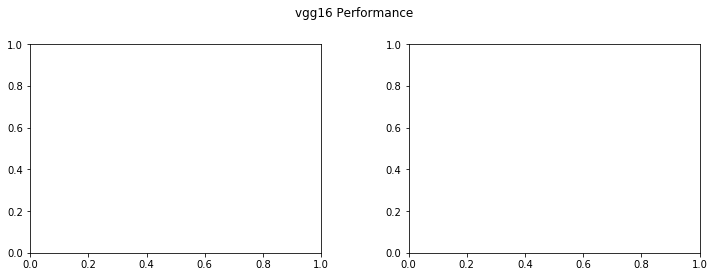

In [0]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('vgg16 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
# Evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

scores = model.evaluate_generator(test_generator) #624 testing images
print("Test Accuracy = ", scores[1])

scores = model.evaluate_generator(validation_generator) #16 validation images
print("validation Accuracy = ", scores[1])

#scores = model.predict_generator(test_generator) #624 testing images
#print("first prediction = ", scores[0])




acc: 89.74%
Test Accuracy =  0.8974359
validation Accuracy =  0.875


**Confution Matrix and Classification Report**

In [0]:
Y_pred = model.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 78 156]
 [130 260]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.38      0.33      0.35       234
   PNEUMONIA       0.62      0.67      0.65       390

   micro avg       0.54      0.54      0.54       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.53      0.54      0.54       624



**Lets try to do something funky,we will change our previous model with some convolutional layers,pooling layers and dropouts as below and see if it does better than the previous one or not**

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import fnmatch
import keras
from time import sleep
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as k


model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))

model.add(Conv2D(32,(7,7),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(GlobalAveragePooling2D())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))



model.layers[0].trainable = False
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])






In [0]:
model.fit_generator(
       train_generator, # specify where model gets training data
       epochs = EPOCHS,
       steps_per_epoch=STEPS,
       validation_data=validation_generator,
       validation_steps=num_of_test_samples // batch_size,
       ) # specify where model gets validation data
